In [53]:
import numpy as np
import pandas as pd
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns

In [54]:
df = load_data("Boston")
y = df['nox']
dis = df['dis']
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [55]:
# Fit a cubic poly
poly_dis = MS([poly('dis',degree=3)]).fit(df)
M = sm.OLS(y, poly_dis.transform(df)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


In [56]:
# Plotting function
def plot_nox_fit(dis_df,
                 basis, # This encodes the model that we want to plot
                 title):
    X = basis.transform(df)
    Xnew = basis.transform(dis_df)
    M = sm.OLS(y,X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis, y, facecolor='gray', alpha=0.5)
    # zip() pairs the elements in two different arrays together 
    # zip([a1,a2], [b1,b2]) = ([a1,b1],[a2,b2])
    for val, ls in zip([preds.predicted_mean,  # the actual line
                        bands[:,0], # bands has the confidence interval lines
                        bands[:,1]],
                        ['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20)
    return ax

In [57]:
# We want predictions for all of the following ages
dis_grid = np.linspace(dis.min(),
                       dis.max(),
                       100)
dis_df = pd.DataFrame({'dis': dis_grid})

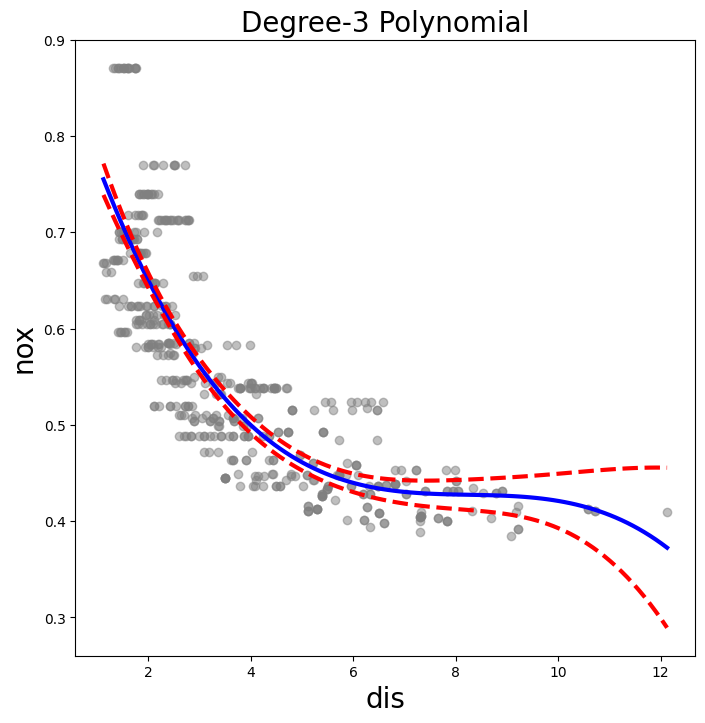

In [58]:
# Plotting cubic fit
RSS = plot_nox_fit(dis_df,
              poly_dis,
              'Degree-3 Polynomial');

In [59]:
# RSS of cubic
M.ssr

1.9341067071790703

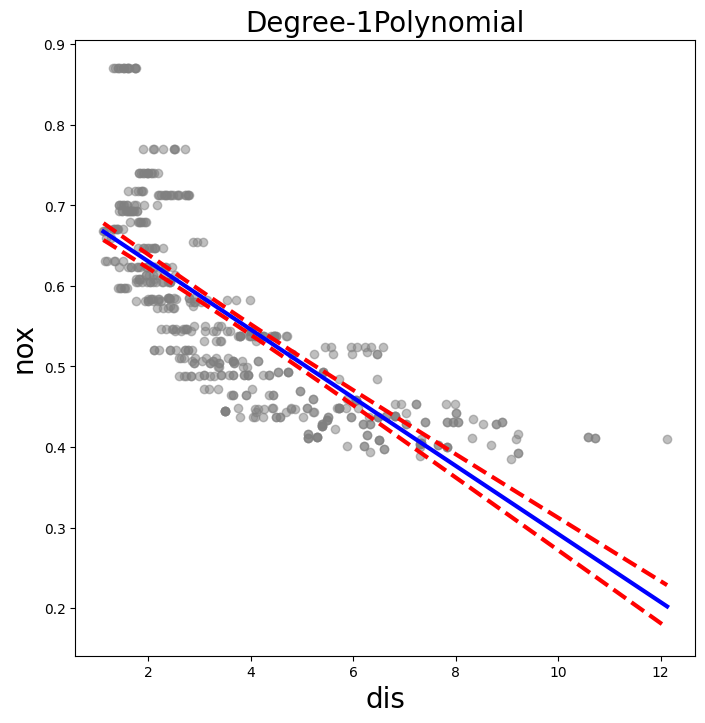

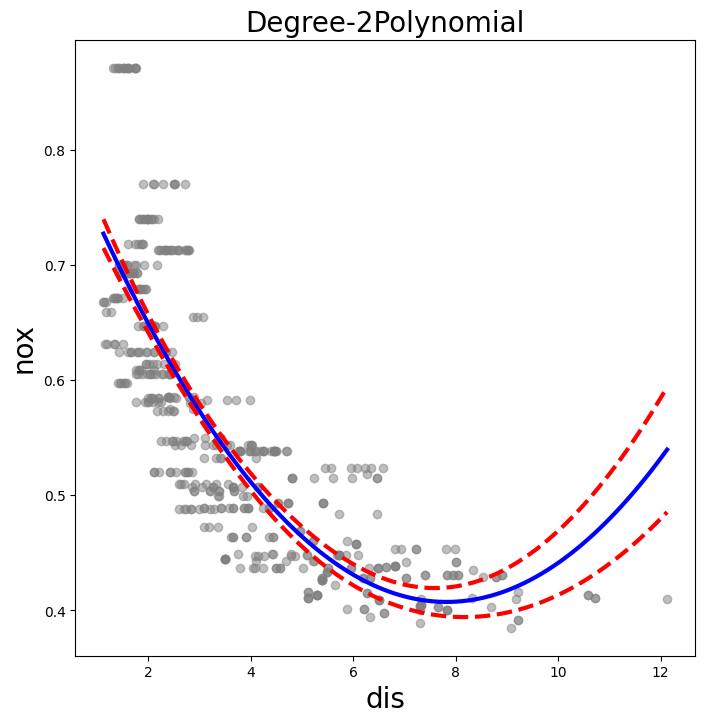

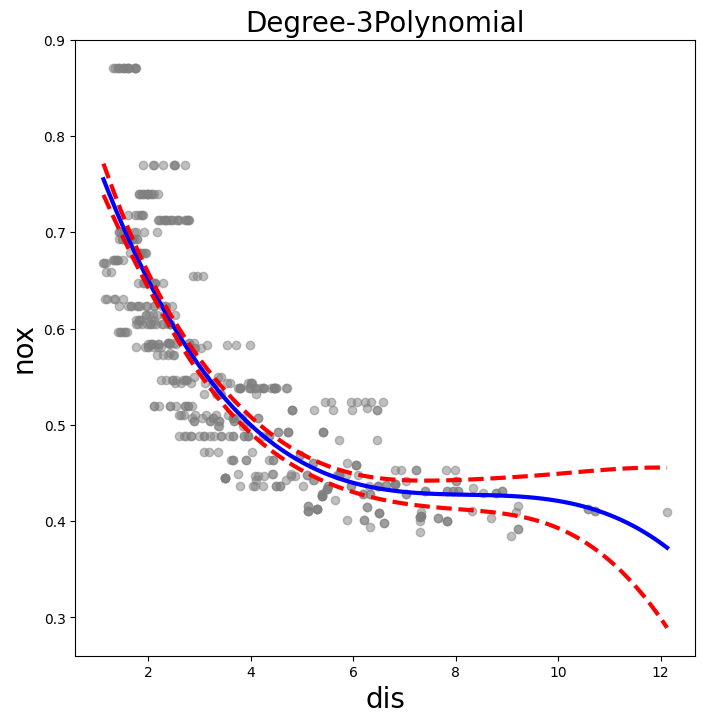

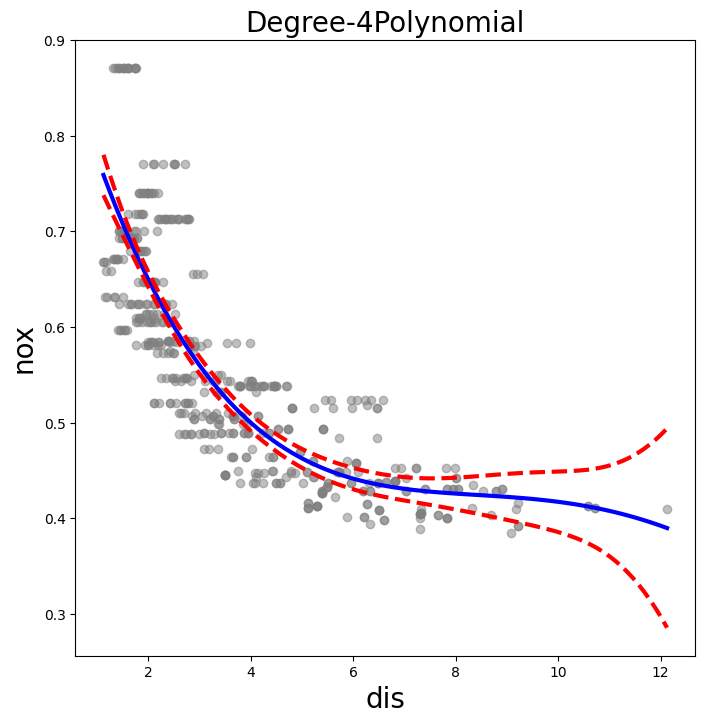

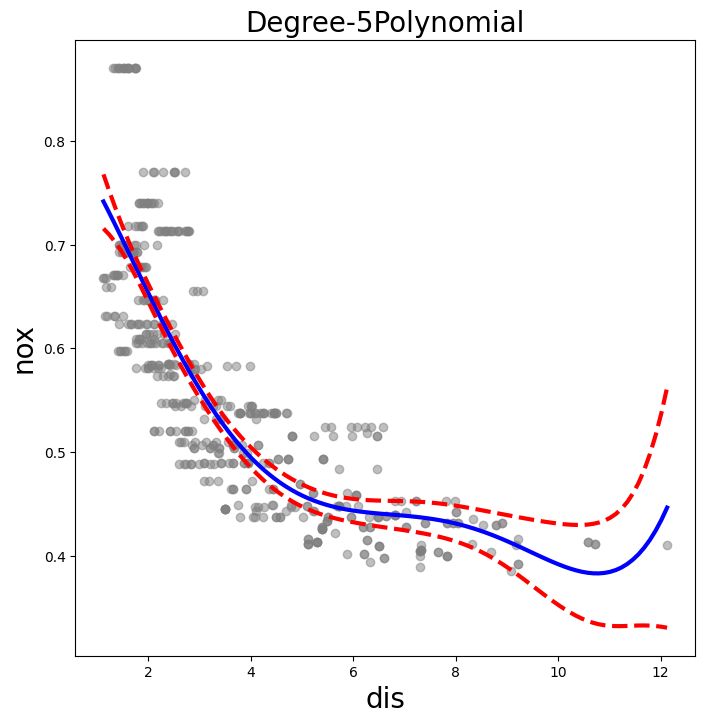

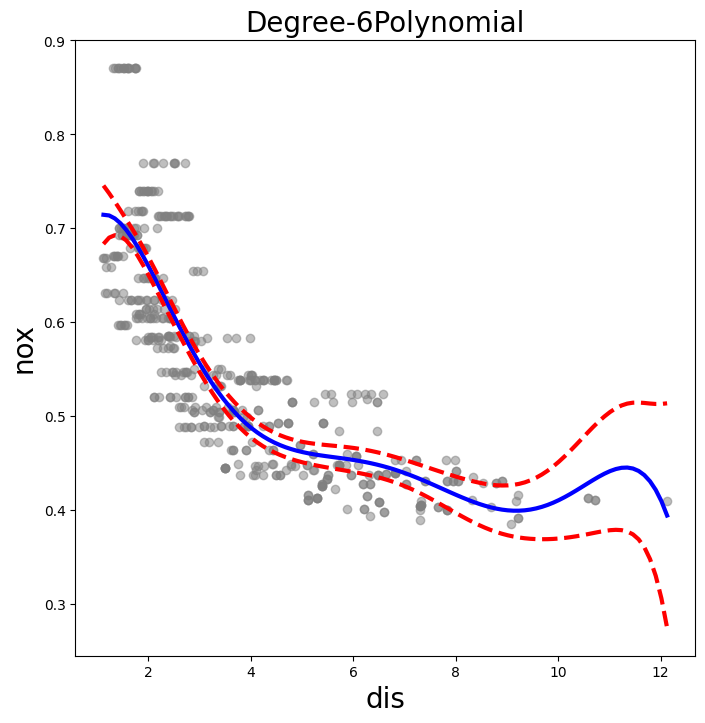

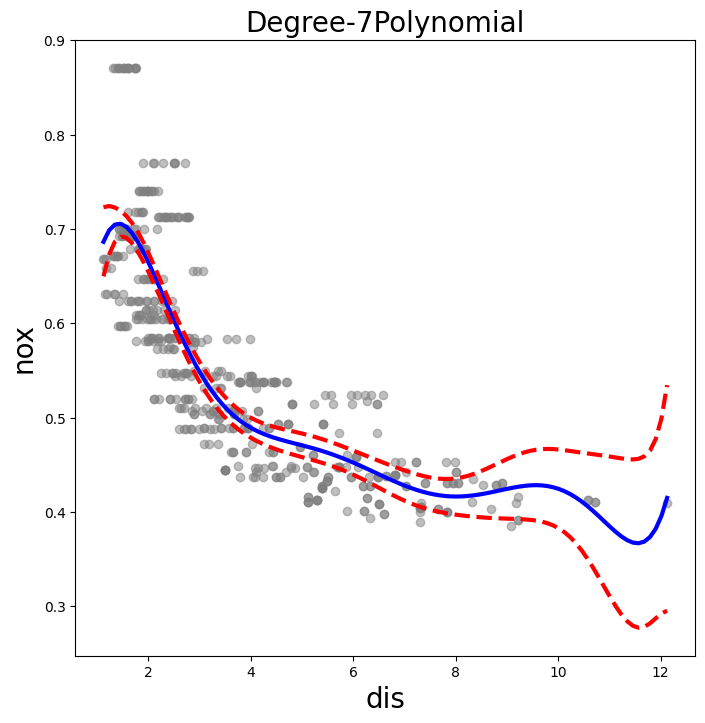

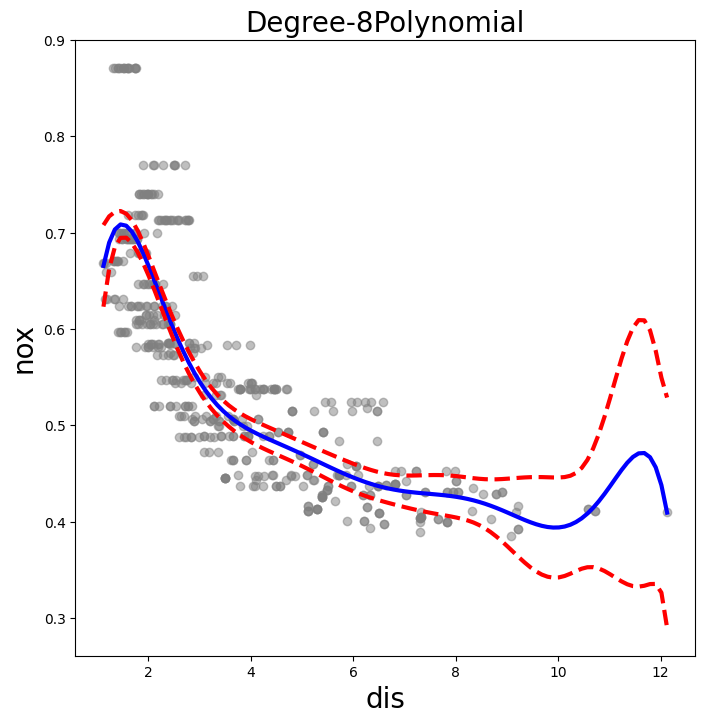

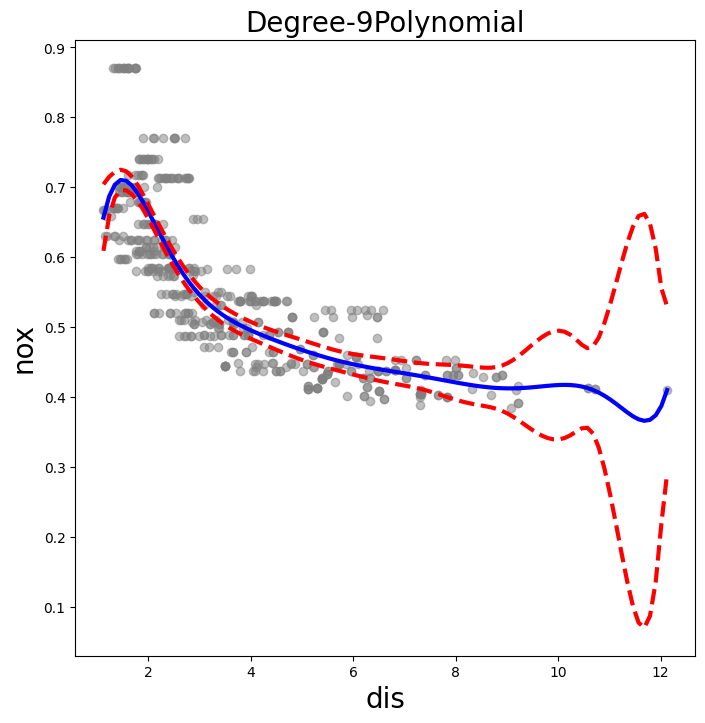

In [60]:
# Plotting poly from degree 1 to 10
for deg in range(1,10):
    poly_dis = MS([poly('dis',degree=deg)]).fit(df)
    M = sm.OLS(y, poly_dis.transform(df)).fit()
    dis_grid = np.linspace(dis.min(),
                       dis.max(),
                       100)
    dis_df = pd.DataFrame({'dis': dis_grid})
    RSS = plot_nox_fit(dis_df,
              poly_dis,
              'Degree-'+str(deg)+ 'Polynomial');

In [61]:
# ANOVA 
models = [MS([poly('age',degree=d)])
          for d in range(1,10)]
XEs = [model.fit_transform(df)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])
# Optimal degree is quadratic

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,3.152816,0.0,NaN,NaN,NaN
1,503.0,2.901743,1.0,0.251072,43.187580,1.245416e-10
2,502.0,2.897361,1.0,0.004382,0.753741,3.857093e-01
3,501.0,2.897275,1.0,0.000087,0.014901,9.028926e-01
4,500.0,2.895133,1.0,0.002141,0.368308,5.442034e-01
5,499.0,2.894664,1.0,0.000469,0.080670,7.765096e-01
6,498.0,2.889462,1.0,0.005202,0.894857,3.446233e-01
7,497.0,2.883807,1.0,0.005655,0.972767,3.244709e-01
8,496.0,2.883513,1.0,0.000294,0.050643,8.220416e-01


In [62]:
# Fitting Regression Spline
# BSpline() funciton gens matrix of basis functions w/ cubic fits by default
bs_ = BSpline(internal_knots=[6], intercept=True).fit(dis) # Choose knot at middle
bs_dis = bs_.transform(dis)
bs_dis.shape # 5 columns as expected since 4 deg of freedom in cubic spleen w 1 knot

(506, 5)

In [63]:
# Fitting
bs_dis = MS([bs('dis', internal_knots=[6],
               name='bs(dis)')]) # setting left most column label
Xbs = bs_dis.fit_transform(df)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.7604,0.010,74.667,0.0
bs(dis)[0],-0.2367,0.023,-10.200,0.0
bs(dis)[1],-0.3618,0.025,-14.200,0.0
bs(dis)[2],-0.3334,0.040,-8.244,0.0
bs(dis)[3],-0.3622,0.051,-7.095,0.0


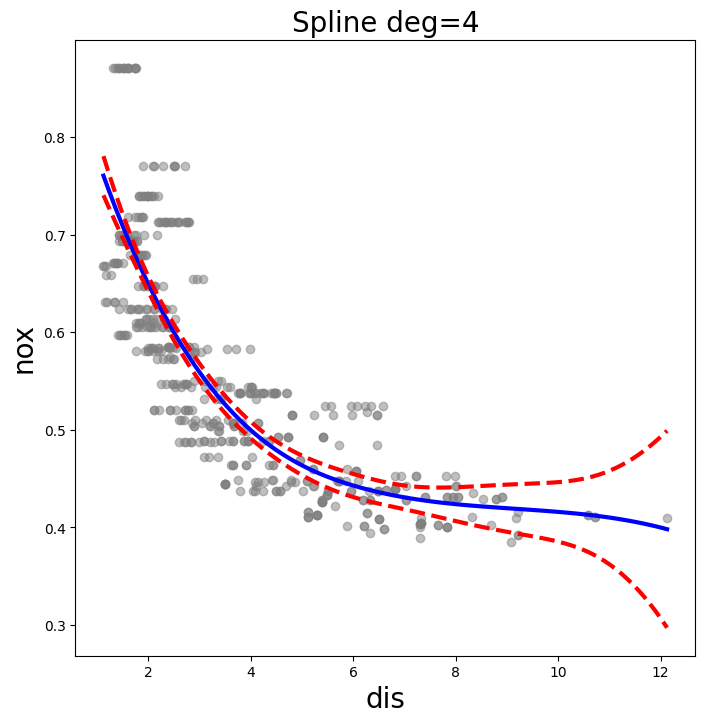

In [64]:
plot_nox_fit(dis_df,
             bs_dis,
             'Spline deg=4');

Train RSS for deg 4: 1.931108703442869
Train RSS for deg 5: 1.9185672212829599
Train RSS for deg 6: 1.8687379141238314
Train RSS for deg 7: 1.8423232878012714
Train RSS for deg 8: 1.8302355227682574
Train RSS for deg 9: 1.8308568774176983


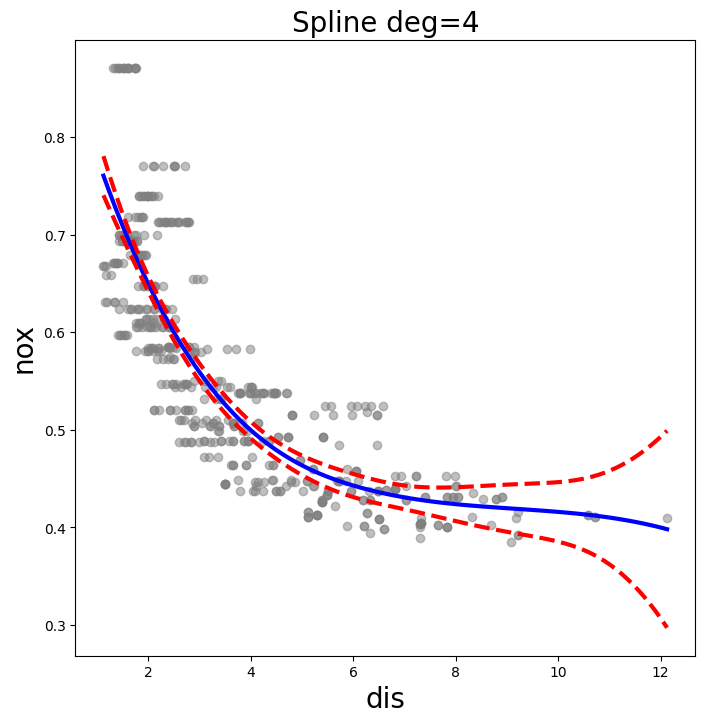

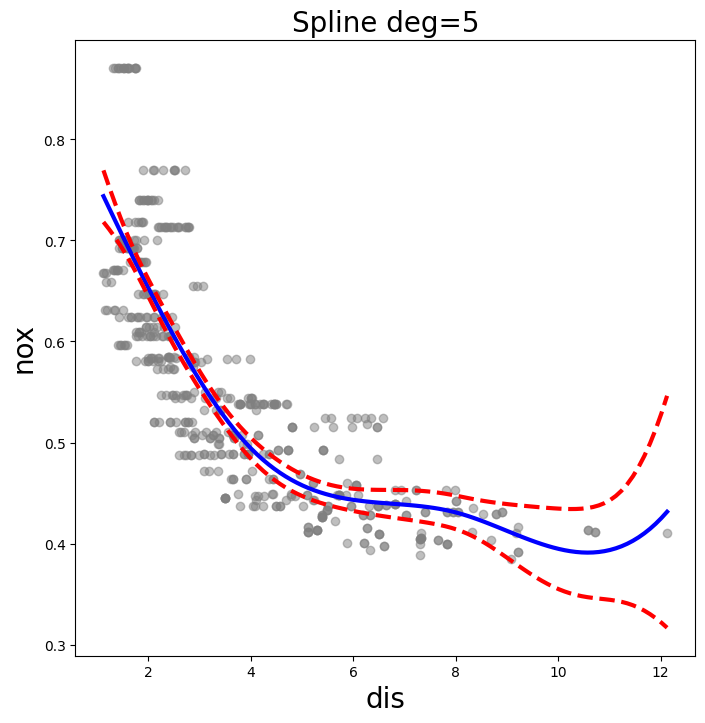

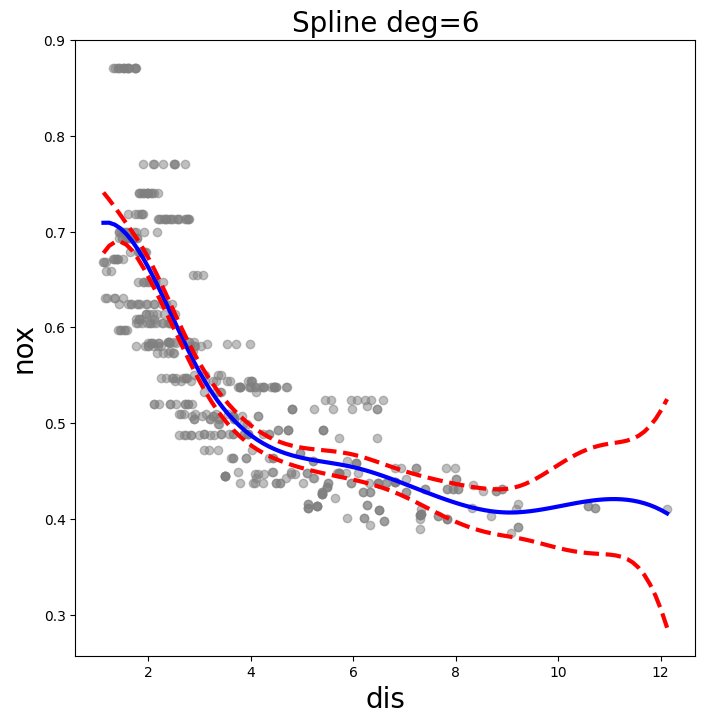

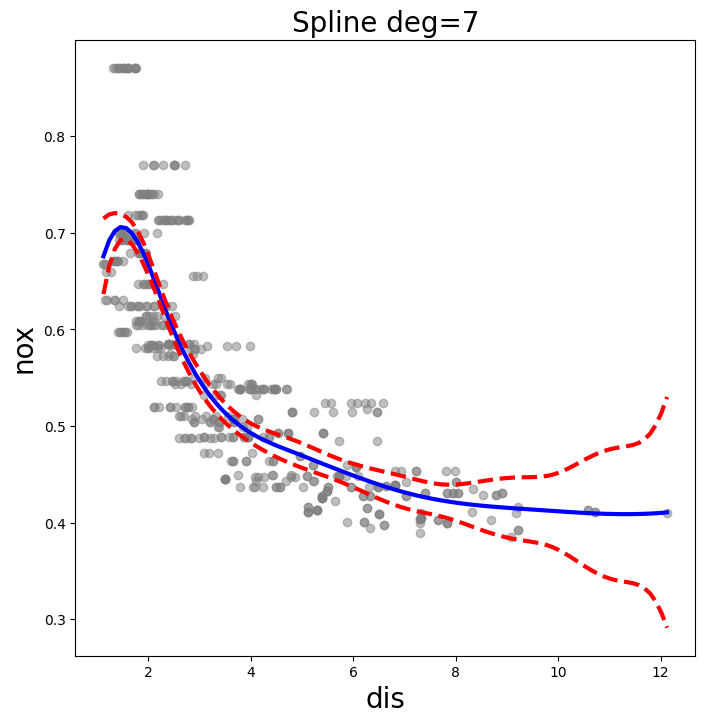

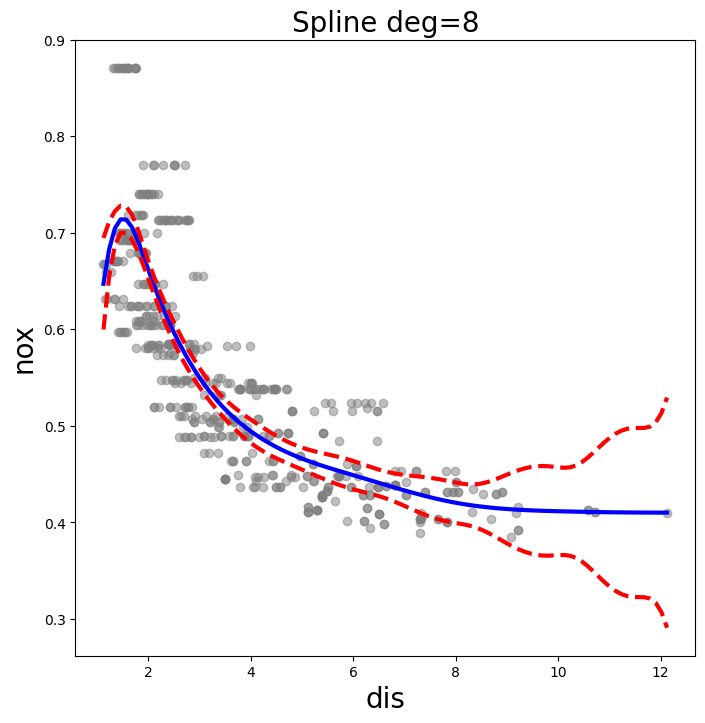

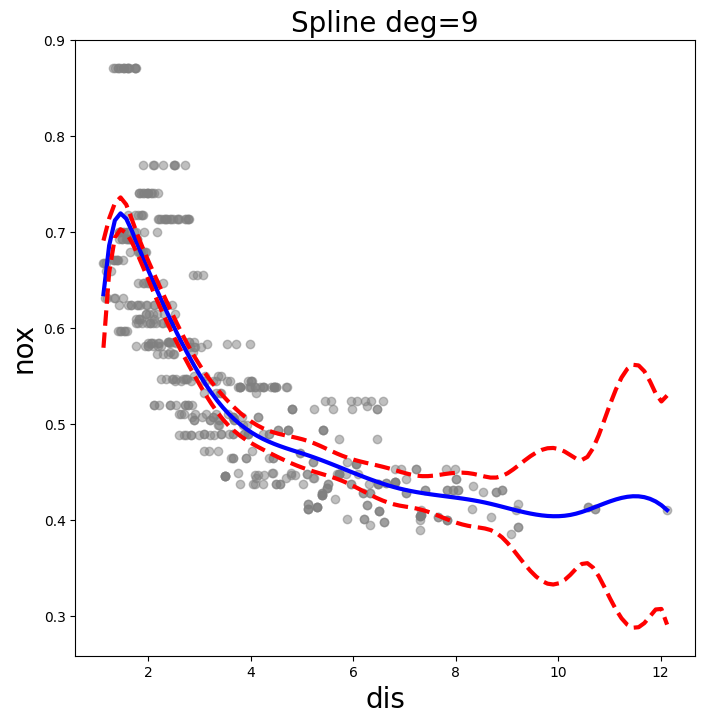

In [69]:
models = []
for knots in range(1,7):
    bs_ = BSpline(internal_knots=
                  np.delete(np.linspace(start=0,stop=12,num=knots+2),[-1,0]),  # shenanigans to get proper knots
                  intercept=True).fit(dis) 
    bs_dis = bs_.transform(dis)
    # Fitting
    bs_dis = MS([bs('dis', 
                    internal_knots=np.delete(np.linspace(start=0,stop=12,num=knots+2),[-1,0]),
                   name='bs(dis)')]) # setting left most column label
    Xbs = bs_dis.fit_transform(df)
    models.append(Xbs)
    M = sm.OLS(y, Xbs).fit()
    print("Train RSS for deg " + str(knots+3) + ": " + str(M.ssr))
    plot_nox_fit(dis_df,
             bs_dis,
             'Spline deg='+str(knots+3));

In [70]:
# ANOVA 
anova_lm(*[sm.OLS(y, X_).fit() for X_ in models])
# Optimal degree is 7, so cubic fit

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,501.0,1.931109,0.0,NaN,NaN,NaN
1,500.0,1.918567,1.0,0.012541,3.397630,0.065882
2,499.0,1.868738,1.0,0.049829,13.499327,0.000264
3,498.0,1.842323,1.0,0.026415,7.156023,0.007717
4,497.0,1.830236,1.0,0.012088,3.274713,0.070959
5,496.0,1.830857,1.0,-0.000621,-0.168332,1.000000
